# Unet training using `fastai2` library

This code is inspired on muellerz camvid notebook. It can be found here: https://github.com/muellerzr/Practical-Deep-Learning-for-Coders-2.0/blob/master/Computer%20Vision/04_Segmentation.ipynb  

In [1]:
import torch
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

In [2]:
path = Path('/mnt/isilon/PanNuke/')

In [3]:
image_path = path/'Images_png/'
mask_path = path/'Masks_png/'

In [4]:
fnames = get_image_files(image_path)
lbl_names = get_image_files(mask_path)

In [6]:
# for i in lbl_names:
#     msk = PILMask.create(i)
#     print(TensorMask(msk).min())
#     print(TensorMask(msk).max())

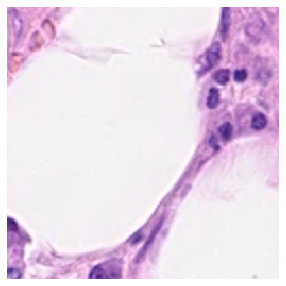

In [5]:
img_fn = fnames[1]
img = PILImage.create(img_fn)
img.show(figsize=(5,5))

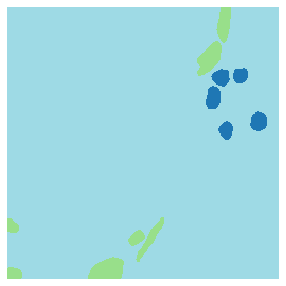

In [6]:
def get_msk(x): return mask_path/f'{x.stem}.png'
msk = PILMask.create(get_msk(img_fn))
msk.show(figsize=(5,5), alpha=1)

In [7]:
codes = np.array(['Neoplastic', 'Lymphocytes', 'Connective', 'Dead', 'Epithelial', 'void'])

In [8]:
#Stats are supposed to help to center values at 0 with sd of 1 but is difficult in H&E images
stats = ([0.6998, 0.5124, 0.6588],[0.1976, 0.2408, 0.2105])

In [9]:
def HImageBlock():  # For DataBlock
    return TransformBlock(type_tfms=[PILImage.create], item_tfms=Resize(256),
                          batch_tfms=[IntToFloatTensor, 
                                      *aug_transforms(do_flip=True, size=256), 
                                      Normalize.from_stats(*stats)])

he = DataBlock(blocks=(HImageBlock, MaskBlock(codes)),
                 get_items = get_image_files,
                 get_y = get_msk,
                 splitter=RandomSplitter())

#he.summary(image_path)

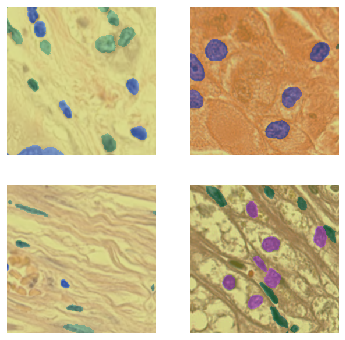

In [12]:
dls = he.dataloaders(image_path, path=path, bs=4)
dls.vocab = codes
#lung.summary(image_path)
dls.show_batch()

In [13]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.1036, 0.3429, 0.2878], device='cuda:0'),
 TensorImage([0.9359, 0.9957, 0.8475], device='cuda:0'))

In [14]:
codes

array(['Neoplastic', 'Lymphocytes', 'Connective', 'Dead', 'Epithelial',
       'void'], dtype='<U11')

In [15]:
name2id = {v:k for k,v in enumerate(codes)}

In [16]:
name2id

{'Neoplastic': 0,
 'Lymphocytes': 1,
 'Connective': 2,
 'Dead': 3,
 'Epithelial': 4,
 'void': 5}

In [17]:
void_code = name2id['void']
#Accuracy is defined as number of correct pixels / total pixels without void class
def acc_camvid(inp, targ):
    targ = targ.squeeze(1)
    mask = targ != void_code
    return (inp.argmax(dim=1)[mask]==targ[mask]).float().mean()

In [18]:
def get_dls(bs, size):
    def HImageBlock():  # For DataBlock
        return TransformBlock(type_tfms=[PILImage.create], 
                          item_tfms=Resize(size),
                          batch_tfms=[IntToFloatTensor, *aug_transforms(do_flip=True, size=size),
                                      Normalize.from_stats(*stats)])

    he = DataBlock(blocks=(HImageBlock, MaskBlock(codes)),
                 get_items = get_image_files,
                 get_y = get_msk,
                 splitter=RandomSplitter())
    return he.dataloaders(image_path, path=path, bs=bs)

In [19]:
dls = get_dls(8, 128)

In [19]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)#, eps=1e-8)
learn = unet_learner(dls, resnet34, loss_func=CrossEntropyLossFlat(axis=1), opt_func=opt_func, path=path, metrics=acc_camvid,
                     config = unet_config(norm_type=None), wd_bn_bias=True)

In [22]:
learn.fine_tune(10, freeze_epochs = 10, cbs=[EarlyStoppingCallback(monitor='acc_camvid', patience=3), SaveModelCallback(monitor='acc_camvid', with_opt=True, fname='fastai2_PanNuke_128_40X')])

epoch,train_loss,valid_loss,acc_camvid,time
0,0.319116,0.296898,0.556597,01:04
1,0.297806,0.298819,0.608036,01:03
2,0.328531,0.302139,0.564724,01:04
3,0.301907,0.283718,0.567473,01:02
4,0.297255,0.291729,0.563025,01:04


No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,acc_camvid,time
0,0.302992,0.285159,0.579531,01:15
1,0.295134,0.282160,0.573852,01:13
2,0.320997,0.323883,0.546772,01:13
3,0.304694,0.274932,0.610994,01:13
4,0.291998,0.333883,0.643214,01:13
5,0.260243,0.274272,0.619527,01:14
6,0.260583,0.245642,0.611570,01:14
7,0.250277,0.242617,0.643146,01:13


No improvement since epoch 4: early stopping


In [31]:
learn.dls = get_dls(4, 256)

In [24]:
learn.fine_tune(10, freeze_epochs = 10, cbs=[EarlyStoppingCallback(monitor='acc_camvid', patience=3), SaveModelCallback(monitor='acc_camvid', with_opt=True, fname='fastai2_PanNuke_256_40X')])

epoch,train_loss,valid_loss,acc_camvid,time
0,0.310610,0.300533,0.575083,03:02
1,0.338552,0.288183,0.590327,03:00
2,0.311124,0.305106,0.564120,03:04
3,0.335905,0.306578,0.517836,03:02
4,0.313431,0.434465,0.554825,03:03


No improvement since epoch 1: early stopping


epoch,train_loss,valid_loss,acc_camvid,time
0,0.287450,0.351269,0.586620,03:15
1,0.339542,0.330318,0.575480,03:08
2,0.314356,0.302569,0.611627,03:06
3,0.296736,0.351430,0.571061,03:10
4,0.273660,0.481576,0.554500,03:10
5,0.271372,0.346685,0.652119,03:09
6,0.274886,0.363689,0.615790,03:06
7,0.262939,0.287508,0.640790,03:07
8,0.219294,0.366121,0.618650,03:07


No improvement since epoch 5: early stopping


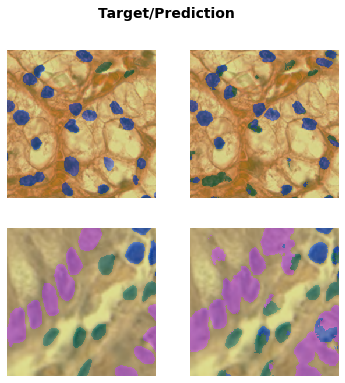

In [41]:
learn.show_results()

Inference and save masks

In [22]:
learn = learn.load('fastai2_PanNuke_256_40X')

In [35]:
dl = learn.dls.test_dl(fnames[:4])

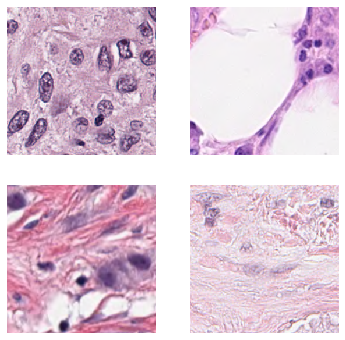

In [36]:
dl.show_batch()

In [37]:
preds = learn.get_preds(dl=dl)

In [42]:
pred_1 = preds[0][2]

In [43]:
pred_arg = pred_1.argmax(dim=0).numpy()

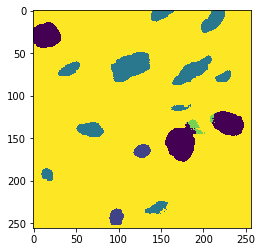

In [45]:
plt.imshow(pred_arg)

In [47]:
#If 255-scaled values are needed
rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
im = Image.fromarray(rescaled)

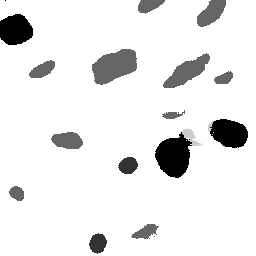

In [48]:
im

In [ ]:
#Loop to save the images
for i, pred in zip(fnames, preds[0]):
    pred_arg = pred.argmax(dim=0).numpy()
    rescaled = (255.0 / pred_arg.max() * (pred_arg - pred_arg.min())).astype(np.uint8)
    im = Image.fromarray(rescaled)
    im.save(f'/test_masks/{i}')